In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [3]:
config = load_config()
od = '../snakemake/compare_external/'

## Get novelty compositions of the other things

93718


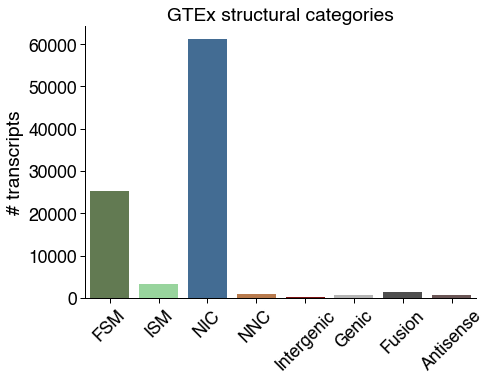

245884


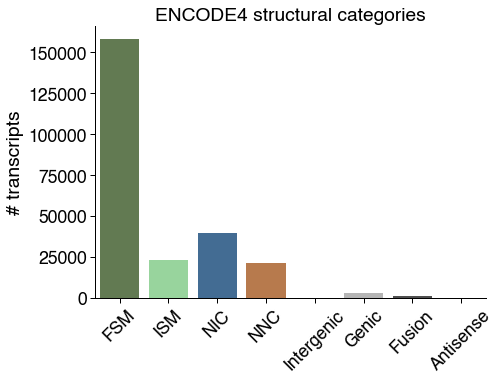

387944


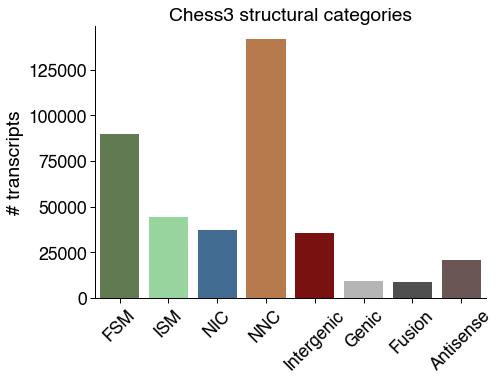

In [9]:
f_dir = '/Users/fairliereese/Documents/programming/mele_lab/projects/240903_pt/ref/compare_external/'
files = [f'{f_dir}gtex_sqanti_classification.txt',
     f'{f_dir}enc_sqanti_classification.txt',
    f'{f_dir}chess_sqanti_classification.txt']
refs = ['GTEx', 'ENCODE4', 'Chess3']

df2 = pd.DataFrame()

for f, r in zip(files, refs):
    df = pd.read_csv(f, sep='\t')
    print(len(df))
    # break
    m = {'antisense': 'Antisense',
     'full-splice_match': 'FSM',
     'fusion': 'Fusion', 
     'genic': 'Genic', 
     'genic_intron': 'Genic', 
     'incomplete-splice_match': 'ISM',
     'novel_in_catalog': 'NIC',
     'novel_not_in_catalog': 'NNC', 
     'intergenic': 'Intergenic'}
    # print(df.structural_category.unique())
    # break
    df['structural_category'] =df['structural_category'].map(m)

    c_dict, order = get_novelty_colors()
    temp = df[['isoform', 'structural_category']].groupby('structural_category').nunique().reset_index()
    init_plot_settings(aspect='rectangle')
    ax = sns.barplot(temp, x='structural_category',
                     y='isoform',
                     palette=c_dict,
                     order=order)
    ax.set(title=f'{r} structural categories', ylabel='# transcripts', xlabel='')
    clean_figure(ax)
    plt.show()
    
    temp['source'] = r
    df2 = pd.concat([temp, df2], axis=0)

In [10]:
df2.to_csv('241113_enc_gtex_sqanti_v47.tsv', sep='\t')

## % FSM in each 

In [11]:
df = pd.read_csv('241113_enc_gtex_sqanti_v47.tsv', sep='\t')

In [12]:
temp = df[['source', 'isoform']].groupby('source').sum().reset_index().rename({'isoform':'total'}, axis=1)
df = df.merge(temp,
              how='left',
              on='source')
df['perc'] = (df['isoform']/df['total'])*100
df.loc[df.structural_category=='FSM']

,Unnamed: 0,structural_category,isoform,source,total,perc
1,1,FSM,89904,Chess3,387944,23.174479
9,1,FSM,158231,ENCODE4,245884,64.351890
17,1,FSM,25312,GTEx,93718,27.008686


## Get by only intron chains

In [48]:
df = pd.DataFrame()
gtfs = [od+config['gtex']['gtf'],
       od+config['enc']['gtf']]
sources = ['GTEx', 'ENCODE4']

for f, s in zip(gtfs, sources):
    temp = pr.read_gtf(f)
    temp = cerberus.get_ic(temp)
    temp['source'] = s
    df = pd.concat([df, temp], axis=0)
    
ics_df = df.copy(deep=True)    

In [59]:
# get structural categories
f_dir = '/Users/fairliereese/Documents/programming/mele_lab/projects/240903_pt/ref/compare_external/'
files = [f'{f_dir}gtex_sqanti_classification.txt',
     f'{f_dir}enc_sqanti_classification.txt']
refs = ['GTEx', 'ENCODE4']

df2 = pd.DataFrame()

for f, r in zip(files, refs):
    df = pd.read_csv(f, sep='\t')
    print(len(df))
    # break
    m = {'antisense': 'Antisense',
     'full-splice_match': 'FSM',
     'fusion': 'Fusion', 
     'genic': 'Genic', 
     'genic_intron': 'Genic', 
     'incomplete-splice_match': 'ISM',
     'novel_in_catalog': 'NIC',
     'novel_not_in_catalog': 'NNC', 
     'intergenic': 'Intergenic'}
    # print(df.structural_category.unique())
    # break
    df['structural_category'] = df['structural_category'].map(m)
    df2 = pd.concat([df2, df], axis=0)

93718
245884


In [60]:
# merge in structural categories
ics_df.head()

,Chromosome,Strand,transcript_id,gene_id,ic,source
0,chr1,-,00146542-c373-4da6-8d48-2242bf43bade_ENSG00000...,ENSG00000160055.19,32222306-32222018-32221866-32221197-32221130-3...,GTEx
1,chr1,-,00294b07-572e-422c-a1bc-6f089eff895c_ENSG00000...,ENSG00000116885.18,36450257-36444033-36444003-36438910-36438755-3...,GTEx
2,chr1,-,00321d78-2502-4c1c-bbac-bb2e5f99582a_ENSG00000...,ENSG00000143549.19,154191901-154191311-154191185-154176248-154176...,GTEx
3,chr1,-,004b70dd-1c22-40d9-912d-cdc35d51c816_ENSG00000...,ENSG00000175756.13,1374996-1374790-1374704-1374590-1373999-1373902,GTEx
4,chr1,-,004f8830-0766-47d5-af4f-11c745414a2d_ENSG00000...,ENSG00000143549.19,154182987-154176248-154176114-154173201-154173...,GTEx


In [62]:
ics_df = ics_df.merge(df2[['isoform', 'structural_category', 'associated_gene']],
                      how='left', 
                      left_on='transcript_id', 
                      right_on='isoform')

In [78]:
ics_df = ics_df.merge(df2[['isoform', 'associated_gene']],
                      how='left', 
                      left_on='transcript_id', 
                      right_on='isoform')

In [79]:
ics_df['ic_id'] = ics_df.Chromosome.astype(str)+'_'+\
                  ics_df.Strand.astype(str)+'_'+\
                  ics_df.ic.astype(str)

In [69]:
# remove monoexonic
print(len(ics_df))
ics_df = ics_df.loc[ics_df.ic != '-']
print(len(ics_df))

339607
314121


In [80]:
temp = ics_df[['ic_id', 'associated_gene', 'structural_category', 'source']].copy(deep=True)

In [81]:
temp.head()

,ic_id,associated_gene,structural_category,source
0,chr1_-_32222306-32222018-32221866-32221197-322...,ENSG00000160055.20,NIC,GTEx
1,chr1_-_36450257-36444033-36444003-36438910-364...,ENSG00000116885.18,NIC,GTEx
2,chr1_-_154191901-154191311-154191185-154176248...,ENSG00000143549.22,NIC,GTEx
3,chr1_-_1374996-1374790-1374704-1374590-1373999...,ENSG00000175756.14,NIC,GTEx
4,chr1_-_154182987-154176248-154176114-154173201...,ENSG00000143549.22,NIC,GTEx


In [82]:
# do we have any weirdos
temp = temp.groupby(['ic_id', 'associated_gene', 'source']).nunique().reset_index().rename({'structural_category':'n_cats'}, axis=1)

In [83]:
temp.loc[temp.n_cats>1]

,ic_id,associated_gene,source,n_cats
336,chr10_+_104123086-104123713-104124124-104125512,ENSG00000156384.15,ENCODE4,2
1303,chr10_+_133389747-133391311,ENSG00000148832.16,ENCODE4,2
1712,chr10_+_26438853-26492326-26492398-26496303-26...,ENSG00000077420.17,ENCODE4,2
2301,chr10_+_50068227-50069546-50069711-50078674-50...,ENSG00000099290.17,ENCODE4,2
3060,chr10_+_73800170-73800295-73800472-73800639-73...,ENSG00000214655.11,ENCODE4,2
...,...,...,...,...
222358,chrX_-_153934883-153934475-153934376-153934001...,ENSG00000102030.16,ENCODE4,2
223730,chrX_-_64395339-64359527-64359404-64356338-643...,ENSG00000102043.16,ENCODE4,2
224066,chrX_-_77785981-77717243-77717130-77698629-776...,ENSG00000085224.23,ENCODE4,2
224067,chrX_-_77785981-77717243-77717130-77698629-776...,ENSG00000085224.23,ENCODE4,2


In [84]:
ics_df.loc[ics_df.ic_id=='chr10_+_104123086-104123713-104124124-104125512']

,Chromosome,Strand,transcript_id,gene_id,ic,source,isoform_x,structural_category,ic_id,isoform_y,associated_gene
117600,chr10,+,"ENSG00000156384[1,4,1]",ENSG00000156384.14,104123086-104123713-104124124-104125512,ENCODE4,"ENSG00000156384[1,4,1]",NIC,chr10_+_104123086-104123713-104124124-104125512,"ENSG00000156384[1,4,1]",ENSG00000156384.15
117601,chr10,+,"ENSG00000156384[2,4,1]",ENSG00000156384.14,104123086-104123713-104124124-104125512,ENCODE4,"ENSG00000156384[2,4,1]",ISM,chr10_+_104123086-104123713-104124124-104125512,"ENSG00000156384[2,4,1]",ENSG00000156384.15


In [86]:
df2.loc[df2.isoform=='ENSG00000156384[1,4,1]']

,isoform,chrom,strand,length,exons,structural_category,associated_gene,associated_transcript,ref_length,ref_exons,...,seq_A_downstream_TTS,dist_to_CAGE_peak,within_CAGE_peak,dist_to_polyA_site,within_polyA_site,polyA_motif,polyA_dist,polyA_motif_found,ORF_seq,ratio_TSS
29236,"ENSG00000156384[1,4,1]",chr10,+,2413,3,NIC,ENSG00000156384.15,novel,1503.0,4.0,...,CAACCATCTATTTCTTCTTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
df2.loc[df2.isoform=='ENSG00000156384[2,4,1]']

,isoform,chrom,strand,length,exons,structural_category,associated_gene,associated_transcript,ref_length,ref_exons,...,seq_A_downstream_TTS,dist_to_CAGE_peak,within_CAGE_peak,dist_to_polyA_site,within_polyA_site,polyA_motif,polyA_dist,polyA_motif_found,ORF_seq,ratio_TSS
29237,"ENSG00000156384[2,4,1]",chr10,+,1508,3,ISM,ENSG00000156384.15,ENST00000369727.4,1430.0,4.0,...,CAACCATCTATTTCTTCTTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
